In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


In [3]:
dataset=pd.read_csv('/content/housing.csv')
dataset=dataset.dropna()
dataset.head(10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,Unnamed: 10
0,-122.23,37.88,41,880,129,322,126.0,8.3252,452600,NEAR,BAY
1,-122.22,37.86,21,7099,1106,2401,1138.0,8.3014,358500,NEAR,BAY
2,-122.24,37.85,52,1467,190,496,177.0,7.2574,352100,NEAR,BAY
3,-122.25,37.85,52,1274,235,558,219.0,5.6431,341300,NEAR,BAY
4,-122.25,37.85,52,1627,280,565,259.0,3.8462,342200,NEAR,BAY
5,-122.25,37.85,52,919,213,413,193.0,4.0368,269700,NEAR,BAY
6,-122.25,37.84,52,2535,489,1094,514.0,3.6591,299200,NEAR,BAY
7,-122.25,37.84,52,3104,687,1157,647.0,3.1200,241400,NEAR,BAY
8,-122.26,37.84,42,2555,665,1206,595.0,2.0804,226700,NEAR,BAY
9,-122.25,37.84,52,3549,707,1551,714.0,3.6912,261100,NEAR,BAY


       longitude  latitude  ...  ocean_proximity  Unnamed: 10
0        -122.23     37.88  ...             NEAR          BAY
1        -122.22     37.86  ...             NEAR          BAY
2        -122.24     37.85  ...             NEAR          BAY
3        -122.25     37.85  ...             NEAR          BAY
4        -122.25     37.85  ...             NEAR          BAY
...          ...       ...  ...              ...          ...
20502    -118.68     34.33  ...              <1H        OCEAN
20503    -118.75     34.33  ...              <1H        OCEAN
20504    -118.73     34.29  ...              <1H        OCEAN
20505    -118.72     34.29  ...              <1H        OCEAN
20506    -118.73     34.29  ...              <1H        OCEAN

[13932 rows x 11 columns]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f1d730f28>,
      dtype=object)

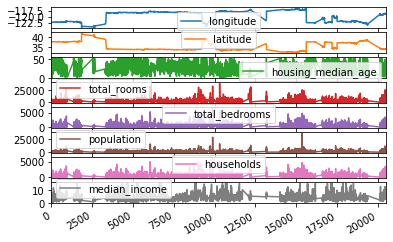

In [4]:
d=dataset
print(d)
#df = pd.DataFrame(d)

#df = pd.DataFrame(d)
#df = pd.DataFrame(d,columns=["longitude","latitude"])
#df.plot(kind="line")
#fig = plt.figure()
#scatter_matrix(dataset,figsize =(10,10),alpha=0.9,diagonal="kde",marker="o")
d.plot(subplots='t')
#plt.subplots(3, 3, sharex='all', sharey='all')


In [0]:
Y=dataset['median_house_value']
X=dataset.loc[:,'longitude':'median_income']

In [0]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3, random_state=2003)
x_train_np=x_train.to_numpy()
y_train_np=y_train.to_numpy()
x_test_np=x_test.to_numpy()
y_test_np=y_test.to_numpy()

In [0]:
import torch
from torch.nn import Conv1d 
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear 
from torch.nn.functional import relu
from torch.utils.data import DataLoader,TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self,batch_size,inputs,outputs):
    super(CnnRegressor,self).__init__()
    self.batch_size=batch_size
    self.inputs=inputs
    self.outputs=outputs
    self.input_layer=Conv1d(inputs,batch_size,1)
    self.max_pooling_layer=MaxPool1d(1)
    self.conv_layer=Conv1d(batch_size,128,1)
    self.flatten_layer=Flatten()
    self.linear_layer=Linear(128,64)
    self.output_layer=Linear(64,outputs)
  def feed(self,input):
    input=input.reshape((self.batch_size, self.inputs,1))
    output=relu(self.input_layer(input))
    output=self.max_pooling_layer(output)
    output=relu(self.conv_layer(output))
    output=self.flatten_layer(output)
    output=self.linear_layer(output)
    output=self.output_layer(output)
    return output


In [9]:
from torch.optim import SGD
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 7.1MB/s 


In [10]:
batch_size=64
model=CnnRegressor(batch_size,X.shape[1],1)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model,dataset,train=False,optimizer=None):
  performance=L1Loss()
  score_metric=R2Score()
  avg_loss=0
  avg_score=0
  count=0
  for input,output in iter(dataset):
    predictions=model.feed(input)
    loss=performance(predictions,output)
    score_metric.update([predictions,output])
    score=score_metric.compute()
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss += loss.item()
    avg_score += score
    count+=1


  return avg_loss/count,avg_score/count


In [12]:
y_train_np = y_train_np.astype(float)
print(y_train_np)

[225400. 350000. 353800. ... 200000. 500001. 264400.]


In [13]:
epochs=1000
optimizer=SGD(model.parameters(),lr=1e-7)
inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)

for epoch in range(epochs):
  avg_loss,avg_r2_score=model_loss(model,loader,train=True,optimizer=optimizer)
  print("Epoch"+str(epoch+1)+":\n\tLoss="+str(avg_loss)+"\n\tR^2 score="+str(avg_r2_score))


Epoch1:
	Loss=245599.81733141447
	R^2 score=-4.746655186319994
Epoch2:
	Loss=245559.62438322368
	R^2 score=-4.699591687344103
Epoch3:
	Loss=245305.32432154604
	R^2 score=-4.793466795159697
Epoch4:
	Loss=245303.60752467104
	R^2 score=-4.631791881132421
Epoch5:
	Loss=245396.83110608553
	R^2 score=-4.662111390013311
Epoch6:
	Loss=245156.84560032896
	R^2 score=-4.655455233096679
Epoch7:
	Loss=245125.85269325657
	R^2 score=-4.743827729066314
Epoch8:
	Loss=244979.09580592104
	R^2 score=-4.7102529479859845
Epoch9:
	Loss=244693.35145970396
	R^2 score=-4.750603579636706
Epoch10:
	Loss=244690.83192845396
	R^2 score=-4.645248606962553
Epoch11:
	Loss=244418.98828125
	R^2 score=-4.633760628581401
Epoch12:
	Loss=244167.82648026315
	R^2 score=-4.660877742499767
Epoch13:
	Loss=243920.41354851975
	R^2 score=-4.684005814170497
Epoch14:
	Loss=243491.57935855264
	R^2 score=-4.574858325990795
Epoch15:
	Loss=243093.5388569079
	R^2 score=-4.590277878341252
Epoch16:
	Loss=242388.90717516447
	R^2 score=-4.6297

In [14]:
y_test_np = y_test_np.astype(float)
print(y_test_np)

[417600. 206500. 175000. ... 173900. 169500. 207900.]


In [15]:
# Convert the testing set into torch variables for our model using the GPU
# as floats
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()
# Create a DataLoader instance to work with our batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
# Output the average performance of the model
avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

The model's L1 loss is: 62634.148737980766
The model's R^2 score is: 0.4375162272068017
